In [1]:
import torch
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
from uitars import rollout_to_messages
from peft import LoraConfig, get_peft_model
from generate_rollout_batch import deserialize_rollout

/home/tobias/ui-rl/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
ERROR:root:exec: process returned 1. F1031 16:04:07.478224   60113 cred.go:145] print credential failed with error: Failed to retrieve access token:: failure while executing gcloud, with args [config config-helper --format=json]: exit status 1 (err: ERROR: (gcloud.config.config-helper) There was a problem refreshing your current auth tokens: Reauthentication failed. cannot prompt during non-interactive execution.
Please run:

  $ gcloud auth login

to obtain new credentials.

If you have already logged in with a different account, run:

  $ gcloud config set account ACCOUNT

to select an already authenticated account to use.
)


In [3]:
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "ByteDance-Seed/UI-TARS-1.5-7B", 
    device_map="cuda", 
    dtype=torch.bfloat16,
    attn_implementation="flash_attention_2",
)
model.gradient_checkpointing_enable()

ImportError: /lib/x86_64-linux-gnu/libc.so.6: version `GLIBC_2.32' not found (required by /home/tobias/ui-rl/.venv/lib/python3.12/site-packages/flash_attn_2_cuda.cpython-312-x86_64-linux-gnu.so)

In [3]:
lora_config = LoraConfig(
    r=16,
    lora_alpha=32,
    target_modules=["q_proj", "v_proj"],   # You may adjust to match the linear/attention modules in Qwen2_5_VL
    lora_dropout=0.05,
    bias="none",
    task_type="CAUSAL_LM"
)

model = get_peft_model(model, lora_config)
model


PeftModelForCausalLM(
  (base_model): LoraModel(
    (model): Qwen2_5_VLForConditionalGeneration(
      (model): Qwen2_5_VLModel(
        (visual): Qwen2_5_VisionTransformerPretrainedModel(
          (patch_embed): Qwen2_5_VisionPatchEmbed(
            (proj): Conv3d(3, 1280, kernel_size=(2, 14, 14), stride=(2, 14, 14), bias=False)
          )
          (rotary_pos_emb): Qwen2_5_VisionRotaryEmbedding()
          (blocks): ModuleList(
            (0-31): 32 x Qwen2_5_VLVisionBlock(
              (norm1): Qwen2RMSNorm((1280,), eps=1e-06)
              (norm2): Qwen2RMSNorm((1280,), eps=1e-06)
              (attn): Qwen2_5_VLVisionAttention(
                (qkv): Linear(in_features=1280, out_features=3840, bias=True)
                (proj): Linear(in_features=1280, out_features=1280, bias=True)
              )
              (mlp): Qwen2_5_VLMLP(
                (gate_proj): Linear(in_features=1280, out_features=3420, bias=True)
                (up_proj): Linear(in_features=1280, out_feat

In [4]:
model.base_model.model.model.visual.patch_embed.proj.weight.requires_grad

False

In [5]:
rollout = deserialize_rollout("../runs/20251027_105709/rollout_000/rollout.json")

[{'role': 'user',
  'content': [{'type': 'text',
    'text': 'You are a GUI agent. You are given a task and your action history, with screenshots. You need to perform the next action to complete the task.\n\n## Output Format\n```\nThought: ...\nAction: ...\n```\n\n## Action Space\nclick(start_box=\'<|box_start|>(x1,y1)<|box_end|>\')\nleft_double(start_box=\'<|box_start|>(x1,y1)<|box_end|>\')\nright_single(start_box=\'<|box_start|>(x1,y1)<|box_end|>\')\ndrag(start_box=\'<|box_start|>(x1,y1)<|box_end|>\', end_box=\'<|box_start|>(x1,y1)<|box_end|>\')\nhotkey(key=\'\') # Press a hotkey, e.g. \'ctrl+c\' or \'alt+f4\'\ntype(content=\'\') #If you want to submit your input, use "\n" at the end of `content`.\nscroll(start_box=\'<|box_start|>(x1,y1)<|box_end|>\', direction=\'down or up or right or left\')\nwait() #Sleep for 5s and take a screenshot to check for any changes.\nfinished()\ncall_user() # Submit the task and call the user when the task is unsolvable, or when you need the user\'s help
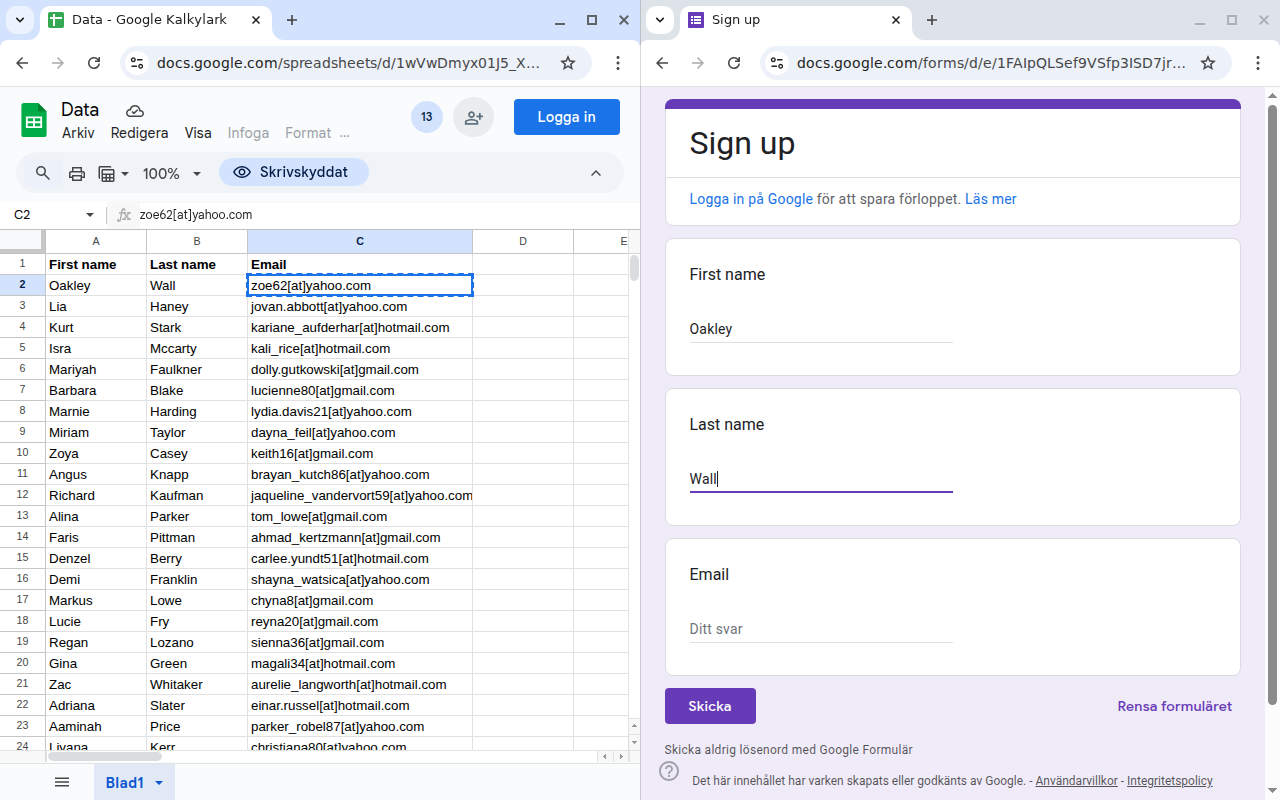

In [9]:
messages = rollout_to_messages(rollout)[:3]
for message in messages:
    if type(message["content"]) != list:
        message["content"] = [{"type": "text", "text": message["content"]}]
    for block in message["content"]:
        if block["type"] == "image_url":
            block["type"] = "image"
            block["image"] = block["image_url"]["url"]
            del block["image_url"]
messages

In [10]:
processor = AutoProcessor.from_pretrained("ByteDance-Seed/UI-TARS-1.5-7B")

In [11]:
inputs = processor.apply_chat_template(messages)

In [12]:
inputs = processor.apply_chat_template(
	messages,
	#add_generation_prompt=True,
	tokenize=True,
	return_dict=True,
	return_tensors="pt",
).to(model.device)

In [13]:
inputs["labels"] = inputs.input_ids
inputs

{'input_ids': tensor([[151644,   8948,    198,  ...,    863, 151645,    198]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1,  ..., 1, 1, 1]], device='cuda:0'), 'pixel_values': tensor([[1.2880, 1.2880, 1.2880,  ..., 2.1317, 2.1317, 2.1317],
        [1.2880, 1.2880, 1.2880,  ..., 2.1317, 2.1317, 2.1317],
        [1.2880, 1.2880, 1.2880,  ..., 2.1317, 2.1317, 2.1317],
        ...,
        [1.8865, 1.8865, 1.8865,  ..., 2.1032, 2.1032, 2.1032],
        [1.7114, 1.7114, 1.7114,  ..., 2.0464, 2.0464, 2.1032],
        [1.8865, 1.8865, 1.9157,  ..., 2.1032, 2.1032, 2.1032]],
       device='cuda:0'), 'image_grid_thw': tensor([[ 1, 58, 92]], device='cuda:0'), 'labels': tensor([[151644,   8948,    198,  ...,    863, 151645,    198]],
       device='cuda:0')}

In [14]:
inputs.input_ids.shape

torch.Size([1, 1792])

In [15]:
from torch.profiler import profile, ProfilerActivity

# 1. Enable memory profiling and capture the forward pass
with profile(activities=[
        ProfilerActivity.CPU, 
        ProfilerActivity.CUDA], 
    profile_memory=True, 
    record_shapes=True) as prof:
    
    # Run your problematic forward pass here
    # Ensure your model and input tensors are on the GPU
    output = model(**inputs)

# 2. Print a table summarizing the CUDA memory events
print(prof.key_averages().table(sort_by="cuda_memory_usage", row_limit=15))

# 3. Optional: Export for a visual timeline (see Step 2)
# prof.export_chrome_trace("trace.json")

-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                                   Name    Self CPU %      Self CPU   CPU total %     CPU total  CPU time avg     Self CUDA   Self CUDA %    CUDA total  CUDA time avg       CPU Mem  Self CPU Mem      CUDA Mem  Self CUDA Mem    # of Calls  
-------------------------------------------------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  ------------  
                                    aten::empty_strided         2.03%      18.567ms         2.22%      20.273ms       5.811us       0.000us         0.00%       0.000us       0.000us      57.55 KB      57.55 KB      12.21 GB      12.21 G

In [17]:
attn_impl = getattr(model.config, "_attn_implementation", "default (eager or sdpa)")
attn_impl

'sdpa'

In [10]:
output

Qwen2_5_VLCausalLMOutputWithPast(loss=None, logits=tensor([[[-1.8359, -5.5625,  0.7578,  ..., -2.8750, -2.8750, -2.8750],
         [ 2.7031,  1.8750,  3.6094,  ..., -2.4844, -2.4844, -2.4844],
         [ 2.8906,  2.0938,  1.7578,  ..., -2.2031, -2.2031, -2.2031],
         ...,
         [-0.4258,  5.4688,  2.6406,  ..., -4.1250, -4.1250, -4.1250],
         [ 0.5938, -1.1484,  2.3281,  ..., -2.2344, -2.2344, -2.2344],
         [-3.6719, -2.1406, -4.8750,  ..., -2.5156, -2.5156, -2.5156]]],
       device='cuda:0', dtype=torch.bfloat16), past_key_values=DynamicCache(layers=[DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer, DynamicLayer]), hidden_states=None, attention

In [28]:
model.print_trainable_parameters()

trainable params: 2,621,440 || all params: 8,294,788,096 || trainable%: 0.0316
